# ANALYSIS

In [ ]:
#uncomment this below code to install imblearn package
# !pip install imbalanced-learn

In [2]:
import pandas as pd
import numpy as np
import sklearn

#statistics
from scipy.stats import chi2_contingency, ttest_ind

import cudf #gpu-powered DataFrame (Pandas alternative)

#imbalance handling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, RepeatedEditedNearestNeighbours
from imblearn.pipeline import Pipeline

#preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler


#internal validation
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedStratifiedKFold, cross_val_score, GridSearchCV, PredefinedSplit, train_test_split

#performance metrices
from sklearn.metrics import confusion_matrix, classification_report, f1_score, balanced_accuracy_score, matthews_corrcoef, auc, average_precision_score, roc_auc_score, balanced_accuracy_score, roc_curve, accuracy_score

#Models selection
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from cuml.svm import SVC #gpu-powered SVM



#save and load trained model
import pickle

#visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree

#Stats
import statsmodels.api as sm 
import statsmodels.formula.api as smf

from collections import Counter
import os

In [22]:
# Data loader
# trainingData = pd.read_csv('../FinalData/trainingData_08102023.csv')
# validationData = pd.read_csv('../FinalData/validationData_08102023.csv')
# evaluationData = pd.read_csv('../FinalData/evaluationData_08102023.csv')
# evaluationDataWales = pd.read_csv('../FinalData/evaluationDataWales_08102023.csv')
# evaluationDataScotland = pd.read_csv('../FinalData/evaluationDataScotland_08102023.csv')


# trainingData = trainingData.rename({'outcome_3months': '3months', 'outcome_combined_6months': '6months','outcome_combined_12months': '12months','outcome_combined_24months': '24months',}, axis=1)
# validationData = validationData.rename({'outcome_3months': '3months', 'outcome_combined_6months': '6months','outcome_combined_12months': '12months','outcome_combined_24months': '24months',}, axis=1)
# evaluationData = evaluationData.rename({'outcome_3months': '3months', 'outcome_combined_6months': '6months','outcome_combined_12months': '12months','outcome_combined_24months': '24months',}, axis=1)
# evaluationDataWales = evaluationDataWales.rename({'outcome_3months': '3months', 'outcome_combined_6months': '6months','outcome_combined_12months': '12months','outcome_combined_24months': '24months',}, axis=1)
# evaluationDataScotland = evaluationDataScotland.rename({'outcome_3months': '3months', 'outcome_combined_6months': '6months','outcome_combined_12months': '12months','outcome_combined_24months': '24months',}, axis=1)

trainingData, validationData, internalEvaluationData, evaluationData, evaluationDataWales, evaluationDataScotland = pickle.load(open('../FinalData/dataset_noOneHot_01122023.sav', 'rb'))

# trainingData = trainingData.rename({'outcome_3months': '3months', 'outcome_combined_6months': '6months','outcome_combined_12months': '12months','outcome_combined_24months': '24months',}, axis=1)
# validationData = validationData.rename({'outcome_3months': '3months', 'outcome_combined_6months': '6months','outcome_combined_12months': '12months','outcome_combined_24months': '24months',}, axis=1)
# internalEvaluationData = internalEvaluationData.rename({'outcome_3months': '3months', 'outcome_combined_6months': '6months','outcome_combined_12months': '12months','outcome_combined_24months': '24months',}, axis=1)
# evaluationData = evaluationData.rename({'outcome_3months': '3months', 'outcome_combined_6months': '6months','outcome_combined_12months': '12months','outcome_combined_24months': '24months',}, axis=1)
# evaluationDataWales = evaluationDataWales.rename({'outcome_3months': '3months', 'outcome_combined_6months': '6months','outcome_combined_12months': '12months','outcome_combined_24months': '24months',}, axis=1)
# evaluationDataScotland = evaluationDataScotland.rename({'outcome_3months': '3months', 'outcome_combined_6months': '6months','outcome_combined_12months': '12months','outcome_combined_24months': '24months',}, axis=1)


EnglandData = pd.concat([trainingData, validationData]).reset_index(drop=True)

In [5]:
##remove sex=2 in England data
EnglandData = EnglandData[EnglandData.sex!=2]

In [23]:
target_outcomes = ['outcome_combined_12months'] 
for target_outcome in target_outcomes:
    print('#######################################################')
    print(target_outcome)
    print(trainingData[target_outcome].value_counts(normalize=True))
    print(validationData[target_outcome].value_counts(normalize=True))
    print(evaluationData[target_outcome].value_counts(normalize=True))
    print(evaluationDataWales[target_outcome].value_counts(normalize=True))
    print(evaluationDataScotland[target_outcome].value_counts(normalize=True))

#######################################################
outcome_combined_12months
0    0.875911
1    0.124089
Name: outcome_combined_12months, dtype: float64
0    0.875916
1    0.124084
Name: outcome_combined_12months, dtype: float64
0    0.830827
1    0.169173
Name: outcome_combined_12months, dtype: float64
0    0.841329
1    0.158671
Name: outcome_combined_12months, dtype: float64
0    0.811984
1    0.188016
Name: outcome_combined_12months, dtype: float64


In [32]:
#Define feature candidates

features_columns = trainingData.columns.to_list()
exclude_columns = ['patid', 'practice_id', #identifier
                   'BMI', #use the categorical instead
                   'ethnicity', #use ethnic_group instead
                   'Spacer',  #all zero
                   
                   'outcome_3months', 'outcome_6months', 'outcome_9months', 'outcome_12months', 'outcome_15months', 'outcome_18months', 
                   'outcome_21months', 'outcome_24months', 'outcome_combined_6months', 'outcome_combined_9months',
                   'outcome_combined_15months', 'outcome_combined_18months', 'outcome_combined_24months', '3months', '6months', '24months', #outcomes variable
                   
                   'outcome_combined_12months', 
                   
                   'postcode_district', 'County', 'LocalAuthority', 'OutputAreaClassification', #location related variables, use IMD decile only
                   
                   'cat_age', 'cat_average_daily_dose_ICS', 'cat_prescribed_daily_dose_ICS', 'cat_ICS_medication_possesion_ratio', 'cat_numOCS', 'cat_numOCSEvents', 
                   'cat_numOCSwithLRTI', 'cat_numAcuteRespEvents', 'cat_numAntibioticsEvents', 'cat_numAntibioticswithLRTI', 'cat_numAsthmaAttacks', 'cat_numHospEvents', 
                   'cat_numPCS', 'cat_numPCSAsthma', #use continous vars instead
                   
                   'count_rhinitis', 'count_cardiovascular', 'count_heartfailure',
                   'count_psoriasis', 'count_anaphylaxis', 'count_diabetes', 'count_ihd',
                   'count_anxiety', 'count_eczema', 'count_nasalpolyps',
                   'count_paracetamol', 'count_nsaids', 'count_betablocker', #use binary ones
                   
                   'paracetamol', 'nsaids', 'betablocker', #no data in evaluation
                   
                   'numOCSEvents', #duplicate with numOCS
                   
                   'month_12', 'month_4', 'month_5', 'month_10', 'month_1', 'month_6', 'month_3', 
                   'month_11', 'month_8', 'month_9', 'month_7', 'month_2', #month of attacks
                  ]
exclude_columns = exclude_columns + [x for x in features_columns if '_count' in x] #filter out commorbid count variables
features_columns = [x for x in features_columns if x not in exclude_columns]
print('Features size: ', len(features_columns))
print(features_columns)

Features size:  35
['sex', 'age', 'ethnic_group', 'smokingStatus', 'CharlsonScore', 'PEFStatus', 'EosinophilLevel', 'BTS_step', 'average_daily_dose_ICS', 'prescribed_daily_dose_ICS', 'ICS_medication_possesion_ratio', 'DeviceType', 'numOCS', 'PriorEducation', 'numPCS', 'numPCSAsthma', 'numAntibioticsEvents', 'numAntibioticswithLRTI', 'numOCSwithLRTI', 'numAsthmaAttacks', 'numAcuteRespEvents', 'numHospEvents', 'imd_decile', 'system', 'cat_BMI', 'rhinitis', 'cardiovascular', 'heartfailure', 'psoriasis', 'anaphylaxis', 'diabetes', 'ihd', 'anxiety', 'eczema', 'nasalpolyps']


In [25]:
EnglandData[features_columns].head()

,sex,age,ethnic_group,smokingStatus,CharlsonScore,PEFStatus,EosinophilLevel,BTS_step,average_daily_dose_ICS,prescribed_daily_dose_ICS,...,cardiovascular,heartfailure,psoriasis,anaphylaxis,diabetes,ihd,anxiety,eczema,nasalpolyps,outcome_combined_12months
0,0.0,28,not_recorded,Former Smoker,1.0,not_recorded,normal,1.0,0.0,0.0,...,0,0,0,0,0,0,1,1,0,0
1,1.0,15,not_recorded,Non Smoker,1.0,60-80,unknown,0.0,200.0,200.0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,55,Other ethnic group,Non Smoker,0.0,not_recorded,normal,0.0,0.0,0.0,...,1,0,0,0,0,0,1,1,0,0
3,1.0,33,Asian - ethnic group,Former Smoker,1.0,not_recorded,normal,0.0,720.0,640.0,...,0,0,0,0,1,0,0,0,0,0
4,0.0,50,not_recorded,Non Smoker,1.0,not_recorded,normal,3.0,200.0,200.0,...,0,0,0,0,0,0,1,0,0,0


# Risk Factors Analysis

In [26]:
cat_vars = ['sex',
 'ethnic_group',
 'smokingStatus',
 'PEFStatus',
 'EosinophilLevel',
 'BTS_step',
 'DeviceType',
 'PriorEducation',
 'imd_decile',
 'cat_BMI',
 'rhinitis',
 'cardiovascular',
 'heartfailure',
 'psoriasis',
 'anaphylaxis',
 'diabetes',
 'ihd',
 'anxiety',
 'eczema',
 'nasalpolyps',
 'system']


In [27]:
EnglandData.system.unique()

array(['EMIS', 'SystemOne', 'Vision'], dtype=object)

In [42]:
#set reference for cat variables

##England
EnglandData['sex'] = pd.Categorical(EnglandData['sex'], categories=[0., 1.])
EnglandData['ethnic_group'] = pd.Categorical(EnglandData['ethnic_group'],categories = ['White - ethnic group', 'Other ethnic group', 'not_recorded',
       'Asian - ethnic group', 'Mixed ethnic census group',
       'Black - ethnic group'])
EnglandData['smokingStatus'] = pd.Categorical(EnglandData['smokingStatus'], categories=['Non Smoker', 'Former Smoker', 'Active Smoker'])
EnglandData['PEFStatus'] = pd.Categorical(EnglandData['PEFStatus'], categories=['less than 60','60-80', 'more than 80', 'not_recorded'])
EnglandData['EosinophilLevel'] = pd.Categorical(EnglandData['EosinophilLevel'], categories=['normal', 'high', 'unknown'])
EnglandData['BTS_step'] = pd.Categorical(EnglandData['BTS_step'], categories=[1., 2., 3., 4., 5., 0.])
EnglandData['DeviceType'] = pd.Categorical(EnglandData['DeviceType'], categories=['pMDI', 'DPI', 'BAI', 'NEB', 'unknown'])
EnglandData['PriorEducation'] = pd.Categorical(EnglandData['PriorEducation'], categories=[0., 1.])
EnglandData['imd_decile'] = pd.Categorical(EnglandData['imd_decile'], categories=[1,2,3,4,5,6,7,8,9,10,0])
EnglandData['cat_BMI'] = pd.Categorical(EnglandData['cat_BMI'], categories=['normal', 'underweight', 'overweight', 'obese', 'not recorded'])
EnglandData['rhinitis'] = pd.Categorical(EnglandData['rhinitis'], categories=[0, 1])
EnglandData['cardiovascular'] = pd.Categorical(EnglandData['cardiovascular'], categories=[0, 1])
EnglandData['heartfailure'] = pd.Categorical(EnglandData['heartfailure'], categories=[0, 1])
EnglandData['psoriasis'] = pd.Categorical(EnglandData['psoriasis'], categories=[0, 1])
EnglandData['anaphylaxis'] = pd.Categorical(EnglandData['anaphylaxis'], categories=[0, 1])
EnglandData['diabetes'] = pd.Categorical(EnglandData['diabetes'], categories=[0, 1])
EnglandData['ihd'] = pd.Categorical(EnglandData['ihd'], categories=[0, 1])
EnglandData['anxiety'] = pd.Categorical(EnglandData['anxiety'], categories=[0, 1])
EnglandData['eczema'] = pd.Categorical(EnglandData['eczema'], categories=[0, 1])
EnglandData['nasalpolyps'] = pd.Categorical(EnglandData['nasalpolyps'], categories=[0, 1])
EnglandData['sex'] = EnglandData.sex.apply(lambda x: 'female' if x==0 else 'male')
EnglandData['system'] = pd.Categorical(EnglandData['system'], categories=['Vision', 'SystemOne', 'EMIS'])


#Evaluation Set
evaluationData['sex'] = pd.Categorical(evaluationData['sex'], categories=[0., 1.])
evaluationData['ethnic_group'] = pd.Categorical(evaluationData['ethnic_group'],categories = ['White - ethnic group', 'Other ethnic group', 
                                                                                             'not_recorded','Asian - ethnic group', 
                                                                                             'Mixed ethnic census group', 'Black - ethnic group'])
evaluationData['smokingStatus'] = pd.Categorical(evaluationData['smokingStatus'], categories=['Non Smoker', 'Former Smoker', 'Active Smoker'])
evaluationData['PEFStatus'] = pd.Categorical(evaluationData['PEFStatus'], categories=['less than 60','60-80', 'more than 80', 'not_recorded'])
evaluationData['EosinophilLevel'] = pd.Categorical(evaluationData['EosinophilLevel'], categories=['normal', 'high', 'unknown'])
evaluationData['BTS_step'] = pd.Categorical(evaluationData['BTS_step'], categories=[1., 2., 3., 4., 5., 0.])
evaluationData['DeviceType'] = pd.Categorical(evaluationData['DeviceType'], categories=['pMDI', 'DPI', 'BAI', 'NEB', 'unknown'])
evaluationData['PriorEducation'] = pd.Categorical(evaluationData['PriorEducation'], categories=[0., 1.])
evaluationData['imd_decile'] = pd.Categorical(evaluationData['imd_decile'], categories=[1,2,3,4,5,6,7,8,9,10,0])
evaluationData['cat_BMI'] = pd.Categorical(evaluationData['cat_BMI'], categories=['normal', 'underweight', 'overweight', 'obese', 'not recorded'])
evaluationData['rhinitis'] = pd.Categorical(evaluationData['rhinitis'], categories=[0, 1])
evaluationData['cardiovascular'] = pd.Categorical(evaluationData['cardiovascular'], categories=[0, 1])
evaluationData['heartfailure'] = pd.Categorical(evaluationData['heartfailure'], categories=[0, 1])
evaluationData['psoriasis'] = pd.Categorical(evaluationData['psoriasis'], categories=[0, 1])
evaluationData['anaphylaxis'] = pd.Categorical(evaluationData['anaphylaxis'], categories=[0, 1])
evaluationData['diabetes'] = pd.Categorical(evaluationData['diabetes'], categories=[0, 1])
evaluationData['ihd'] = pd.Categorical(evaluationData['ihd'], categories=[0, 1])
evaluationData['anxiety'] = pd.Categorical(evaluationData['anxiety'], categories=[0, 1])
evaluationData['eczema'] = pd.Categorical(evaluationData['eczema'], categories=[0, 1])
evaluationData['nasalpolyps'] = pd.Categorical(evaluationData['nasalpolyps'], categories=[0, 1])
evaluationData['sex'] = evaluationData.sex.apply(lambda x: 'female' if x==0 else 'male')
evaluationData['system'] = pd.Categorical(evaluationData['system'], categories=['Vision', 'SystemOne', 'EMIS'])


#Wales
evaluationDataWales['sex'] = pd.Categorical(evaluationDataWales['sex'], categories=[0., 1.])
evaluationDataWales['ethnic_group'] = pd.Categorical(evaluationDataWales['ethnic_group'],categories = ['White - ethnic group', 'Other ethnic group', 'not_recorded',
       'Asian - ethnic group', 'Mixed ethnic census group',
       'Black - ethnic group'])
evaluationDataWales['smokingStatus'] = pd.Categorical(evaluationDataWales['smokingStatus'], categories=['Non Smoker', 'Former Smoker', 'Active Smoker'])
evaluationDataWales['PEFStatus'] = pd.Categorical(evaluationDataWales['PEFStatus'], categories=['less than 60','60-80', 'more than 80', 'not_recorded'])
evaluationDataWales['EosinophilLevel'] = pd.Categorical(evaluationDataWales['EosinophilLevel'], categories=['normal', 'high', 'unknown'])
evaluationDataWales['BTS_step'] = pd.Categorical(evaluationDataWales['BTS_step'], categories=[1., 2., 3., 4., 5., 0.])
evaluationDataWales['DeviceType'] = pd.Categorical(evaluationDataWales['DeviceType'], categories=['pMDI', 'DPI', 'BAI', 'NEB', 'unknown'])
evaluationDataWales['PriorEducation'] = pd.Categorical(evaluationDataWales['PriorEducation'], categories=[0., 1.])
evaluationDataWales['imd_decile'] = pd.Categorical(evaluationDataWales['imd_decile'], categories=[1,2,3,4,5,6,7,8,9,10])
evaluationDataWales['cat_BMI'] = pd.Categorical(evaluationDataWales['cat_BMI'], categories=['normal', 'underweight', 'overweight', 'obese', 'not recorded'])
evaluationDataWales['rhinitis'] = pd.Categorical(evaluationDataWales['rhinitis'], categories=[0, 1])
evaluationDataWales['cardiovascular'] = pd.Categorical(evaluationDataWales['cardiovascular'], categories=[0, 1])
evaluationDataWales['heartfailure'] = pd.Categorical(evaluationDataWales['heartfailure'], categories=[0, 1])
evaluationDataWales['psoriasis'] = pd.Categorical(evaluationDataWales['psoriasis'], categories=[0, 1])
evaluationDataWales['anaphylaxis'] = pd.Categorical(evaluationDataWales['anaphylaxis'], categories=[0, 1])
evaluationDataWales['diabetes'] = pd.Categorical(evaluationDataWales['diabetes'], categories=[0, 1])
evaluationDataWales['ihd'] = pd.Categorical(evaluationDataWales['ihd'], categories=[0, 1])
evaluationDataWales['anxiety'] = pd.Categorical(evaluationDataWales['anxiety'], categories=[0, 1])
evaluationDataWales['eczema'] = pd.Categorical(evaluationDataWales['eczema'], categories=[0, 1])
evaluationDataWales['nasalpolyps'] = pd.Categorical(evaluationDataWales['nasalpolyps'], categories=[0, 1])
evaluationDataWales['sex'] = evaluationDataWales.sex.apply(lambda x: 'female' if x==0 else 'male')
evaluationDataWales['system'] = pd.Categorical(evaluationDataWales['system'], categories=['Vision', 'SystemOne', 'EMIS'])

#Scotland
evaluationDataScotland['sex'] = pd.Categorical(evaluationDataScotland['sex'], categories=[0., 1.])
evaluationDataScotland['ethnic_group'] = pd.Categorical(evaluationDataScotland['ethnic_group'],categories = ['White - ethnic group', 'Other ethnic group', 'not_recorded',
       'Asian - ethnic group', 'Mixed ethnic census group',
       'Black - ethnic group'])
evaluationDataScotland['smokingStatus'] = pd.Categorical(evaluationDataScotland['smokingStatus'], categories=['Non Smoker', 'Former Smoker', 'Active Smoker'])
evaluationDataScotland['PEFStatus'] = pd.Categorical(evaluationDataScotland['PEFStatus'], categories=['less than 60','60-80', 'more than 80', 'not_recorded'])
evaluationDataScotland['EosinophilLevel'] = pd.Categorical(evaluationDataScotland['EosinophilLevel'], categories=['normal', 'high', 'unknown'])
evaluationDataScotland['BTS_step'] = pd.Categorical(evaluationDataScotland['BTS_step'], categories=[1., 2., 3., 4., 5., 0.])
evaluationDataScotland['DeviceType'] = pd.Categorical(evaluationDataScotland['DeviceType'], categories=['pMDI', 'DPI', 'BAI', 'NEB', 'unknown'])
evaluationDataScotland['PriorEducation'] = pd.Categorical(evaluationDataScotland['PriorEducation'], categories=[0., 1.])
evaluationDataScotland['imd_decile'] = pd.Categorical(evaluationDataScotland['imd_decile'], categories=[1,2,3,4,5,7,8,9,10,0])
evaluationDataScotland['cat_BMI'] = pd.Categorical(evaluationDataScotland['cat_BMI'], categories=['normal', 'underweight', 'overweight', 'obese', 'not recorded'])
evaluationDataScotland['rhinitis'] = pd.Categorical(evaluationDataScotland['rhinitis'], categories=[0, 1])
evaluationDataScotland['cardiovascular'] = pd.Categorical(evaluationDataScotland['cardiovascular'], categories=[0, 1])
evaluationDataScotland['heartfailure'] = pd.Categorical(evaluationDataScotland['heartfailure'], categories=[0, 1])
evaluationDataScotland['psoriasis'] = pd.Categorical(evaluationDataScotland['psoriasis'], categories=[0, 1])
evaluationDataScotland['anaphylaxis'] = pd.Categorical(evaluationDataScotland['anaphylaxis'], categories=[0, 1])
evaluationDataScotland['diabetes'] = pd.Categorical(evaluationDataScotland['diabetes'], categories=[0, 1])
evaluationDataScotland['ihd'] = pd.Categorical(evaluationDataScotland['ihd'], categories=[0, 1])
evaluationDataScotland['anxiety'] = pd.Categorical(evaluationDataScotland['anxiety'], categories=[0, 1])
evaluationDataScotland['eczema'] = pd.Categorical(evaluationDataScotland['eczema'], categories=[0, 1])
evaluationDataScotland['nasalpolyps'] = pd.Categorical(evaluationDataScotland['nasalpolyps'], categories=[0, 1])
evaluationDataScotland['sex'] = evaluationDataScotland.sex.apply(lambda x: 'female' if x==0 else 'male')
evaluationDataScotland['system'] = pd.Categorical(evaluationDataScotland['system'], categories=['Vision', 'SystemOne', 'EMIS'])

In [16]:
col = 'ethnic_group'
formula = "outcome_12months ~ C(" + str(col) + ")"
log_reg = smf.logit(formula=formula, data=EnglandData,).fit()

Optimization terminated successfully.
         Current function value: 0.194408
         Iterations 7


In [17]:
col = 'age'
formula = "outcome_12months ~ " + str(col)
log_reg = smf.logit(formula=formula, data=EnglandData,).fit()

Optimization terminated successfully.
         Current function value: 0.193135
         Iterations 7


In [ ]:
log_reg.conf_int().values[0]

In [ ]:
for i in range(1,len(log_reg.params)):
    print(log_reg.params.index[i], log_reg.params[i], log_reg.pvalues[i], np.exp(log_reg.params[i]), np.exp(log_reg.conf_int().values[i]))

In [ ]:
print(log_reg.pvalues[1], np.exp(log_reg.params[1]).tolist(), np.exp(log_reg.conf_int().values[1]).tolist())

In [ ]:
log_reg.pvalues

## England

In [65]:
data = EnglandData
result = []
excluded_vars = ['ICS_medication_possesion_ratio']
# excluded_vars = []
for col in features_columns:
    print(col)
    if col not in excluded_vars:
        if(len(data[col].unique())>1): #handling Singluar matrix problem
            # log_reg = sm.Logit(data[['12months']], data[[col]]).fit()
            if col in cat_vars:
                formula = "outcome_combined_12months ~ C(" + str(col) + ")"
                log_reg = smf.logit(formula=formula, data=EnglandData).fit()
            else:
                formula = "outcome_combined_12months ~ " + str(col)
                log_reg = smf.logit(formula=formula, data=EnglandData).fit()                

            for i in range(1,len(log_reg.params)):
                sign = ['significant' if log_reg.pvalues[i] < 0.05 else 'not significant']
                result.append([log_reg.params.index[i], log_reg.pvalues[i], log_reg.params[i], np.exp(log_reg.params[i])] + np.exp(log_reg.conf_int().values[i]).tolist() + sign)

result = pd.DataFrame(result, columns=['Var', 'PVal', 'Beta', 'OR', '2.5%', '97.5%', 'Significant?'])
result.index = result.Var


sex
age
Optimization terminated successfully.
         Current function value: 0.370594
         Iterations 6
ethnic_group
Optimization terminated successfully.
         Current function value: 0.374173
         Iterations 6
smokingStatus
Optimization terminated successfully.
         Current function value: 0.371895
         Iterations 6
CharlsonScore
Optimization terminated successfully.
         Current function value: 0.372710
         Iterations 6
PEFStatus
Optimization terminated successfully.
         Current function value: 0.374843
         Iterations 6
EosinophilLevel
Optimization terminated successfully.
         Current function value: 0.370238
         Iterations 6
BTS_step
Optimization terminated successfully.
         Current function value: 0.349677
         Iterations 6
average_daily_dose_ICS
Optimization terminated successfully.
         Current function value: 0.360563
         Iterations 6
prescribed_daily_dose_ICS
Optimization terminated successfully.
         Curr

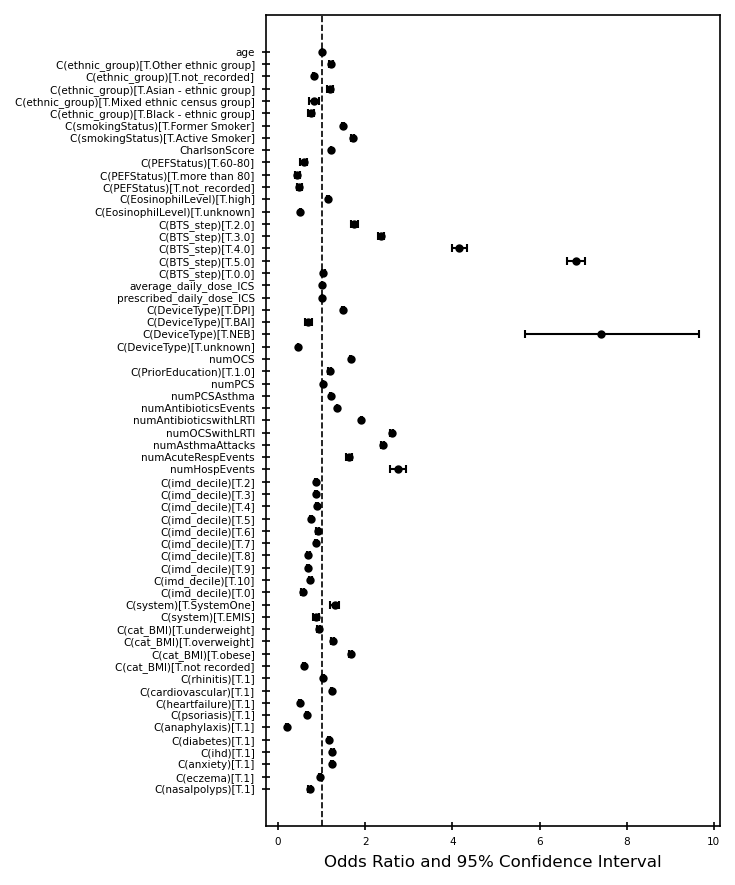

In [66]:
plt.figure(figsize=(5, 6), dpi=150)
ci = [result.iloc[::-1]['OR'] - result.iloc[::-1]['2.5%'].values, result.iloc[::-1]['97.5%'].values - result.iloc[::-1]['OR']]
plt.errorbar(x=result.iloc[::-1]['OR'], y=result.iloc[::-1].index.values, xerr=ci,
            color='black',  capsize=2, linestyle='None', elinewidth=1,
            marker='o', markersize=3, mfc="black", mec="black",barsabove=True,)
plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(direction='inout', axis='both', which='major', labelsize=5)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=8)
plt.tight_layout()
# plt.savefig('raw_forest_plot.png')
plt.show()

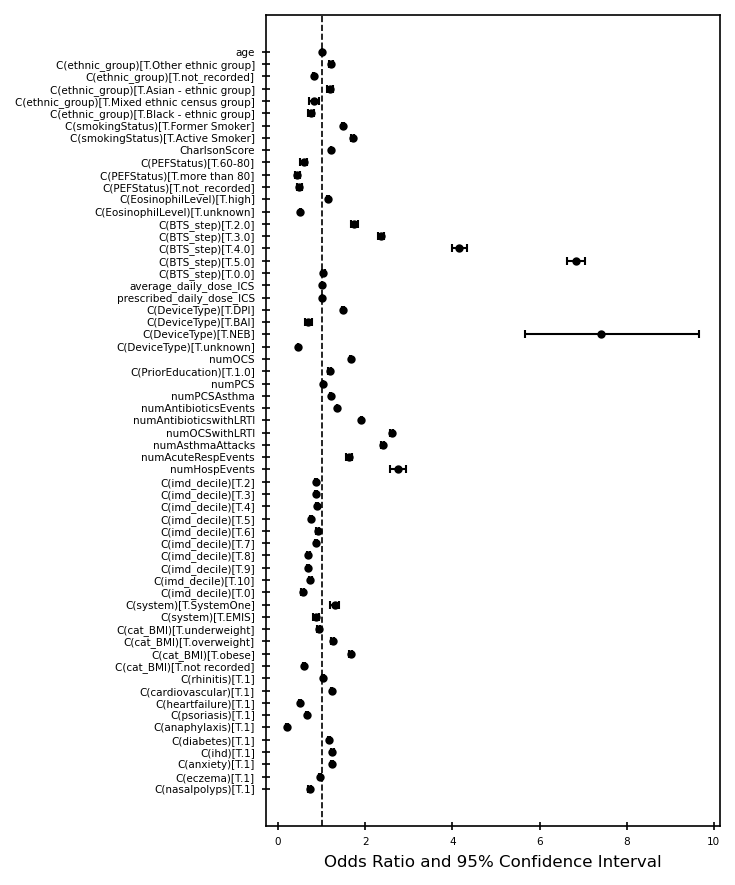

In [67]:
sign_result = result[result['Significant?'] == 'significant']
plt.figure(figsize=(5, 6), dpi=150)
ci = [sign_result.iloc[::-1]['OR'] - sign_result.iloc[::-1]['2.5%'].values, sign_result.iloc[::-1]['97.5%'].values - sign_result.iloc[::-1]['OR']]
plt.errorbar(x=sign_result.iloc[::-1]['OR'], y=sign_result.iloc[::-1].index.values, xerr=ci,
            color='black',  capsize=2, linestyle='None', elinewidth=1,
            marker='o', markersize=3, mfc="black", mec="black",barsabove=True,)
plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(direction='inout', axis='both', which='major', labelsize=5)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=8)
plt.tight_layout()
# plt.savefig('raw_forest_plot.png')
plt.show()

In [68]:
result[result.Var.str.contains('system')]

,Var,PVal,Beta,OR,2.5%,97.5%,Significant?
Var,,,,,,,
C(system)[T.SystemOne],C(system)[T.SystemOne],2.412318e-10,0.262810,1.300579,1.198976,1.410793,significant
C(system)[T.EMIS],C(system)[T.EMIS],7.728902e-04,-0.139845,0.869493,0.801425,0.943342,significant


## Wales

In [77]:
data = evaluationDataWales
data['system'] = pd.Categorical(data['system'], categories=['Vision', 'EMIS'])
# for col in cat_vars:
#     valuecounts = data[col].value_counts()
#     groupsToBeExcluded = valuecounts.index[(valuecounts == 0).values].tolist()
#     for group in groupsToBeExcluded:
#         categories = data[col].cat.categories
#         categories = np.delete(categories, np.where(categories == group))
#         data[col] = pd.Categorical(data[col], categories=categories)
#         print('exclude ', str(group), ' from ', str(col))
        
# print('==========================================================')
result = []
excluded_vars = ['PEFStatus', 'ethnic_group', 'DeviceType', 'ICS_medication_possesion_ratio']
# excluded_vars = []
for col in features_columns:
    print(col)
    if col not in excluded_vars:
        if(len(data[col].unique())>1): #handling Singluar matrix problem
            # log_reg = sm.Logit(data[['12months']], data[[col]]).fit()
            if col in cat_vars:
                formula = "outcome_12months ~ C(" + str(col) + ")"
                log_reg = smf.logit(formula=formula, data=data).fit()
            else:
                formula = "outcome_12months ~ " + str(col)
                log_reg = smf.logit(formula=formula, data=data).fit()                

            for i in range(1,len(log_reg.params)):
                sign = ['significant' if log_reg.pvalues[i] <= 0.05 else 'not significant']
                result.append([log_reg.params.index[i], log_reg.pvalues[i], log_reg.params[i], np.exp(log_reg.params[i])] + np.exp(log_reg.conf_int().values[i]).tolist() + sign)

result = pd.DataFrame(result, columns=['Var', 'PVal', 'Beta', 'OR', '2.5%', '97.5%', 'Significant?'])
result.index = result.Var



sex
age
Optimization terminated successfully.
         Current function value: 0.250627
         Iterations 7
ethnic_group
smokingStatus
Optimization terminated successfully.
         Current function value: 0.250893
         Iterations 7
CharlsonScore
Optimization terminated successfully.
         Current function value: 0.250960
         Iterations 7
PEFStatus
EosinophilLevel
Optimization terminated successfully.
         Current function value: 0.248960
         Iterations 7
BTS_step
Optimization terminated successfully.
         Current function value: 0.239210
         Iterations 7
average_daily_dose_ICS
Optimization terminated successfully.
         Current function value: 0.252370
         Iterations 7
prescribed_daily_dose_ICS
Optimization terminated successfully.
         Current function value: 0.252371
         Iterations 7
ICS_medication_possesion_ratio
DeviceType
numOCS
Optimization terminated successfully.
         Current function value: 0.238968
         Iterations 7
Pr

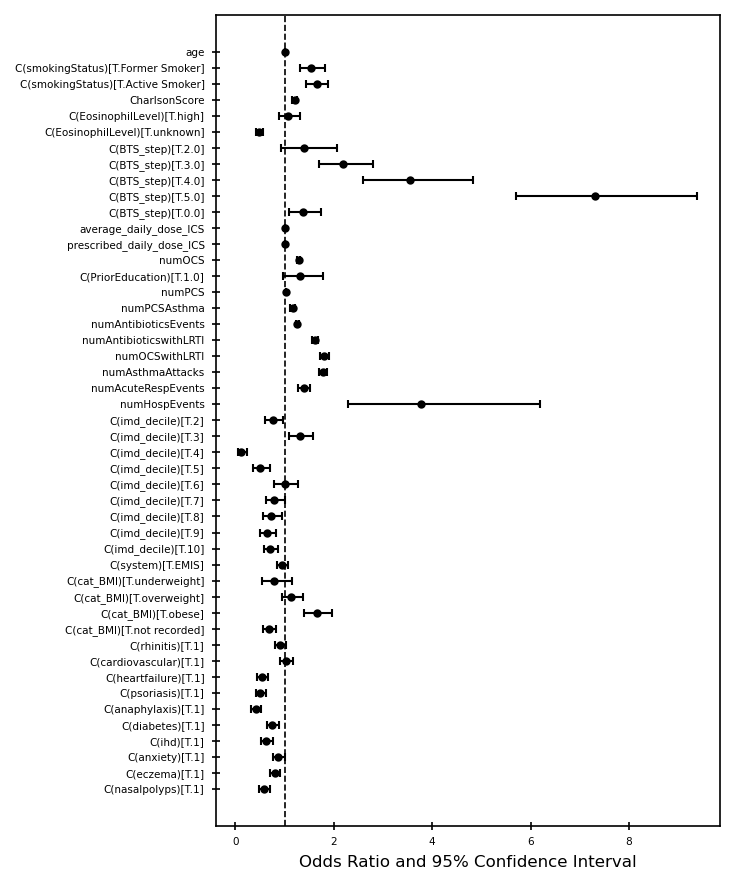

In [78]:
plt.figure(figsize=(5, 6), dpi=150)
ci = [result.iloc[::-1]['OR'] - result.iloc[::-1]['2.5%'].values, result.iloc[::-1]['97.5%'].values - result.iloc[::-1]['OR']]
plt.errorbar(x=result.iloc[::-1]['OR'], y=result.iloc[::-1].index.values, xerr=ci,
            color='black',  capsize=2, linestyle='None', elinewidth=1,
            marker='o', markersize=3, mfc="black", mec="black",barsabove=True,)
plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(direction='inout', axis='both', which='major', labelsize=5)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=8)
plt.tight_layout()
# plt.savefig('raw_forest_plot.png')
plt.show()

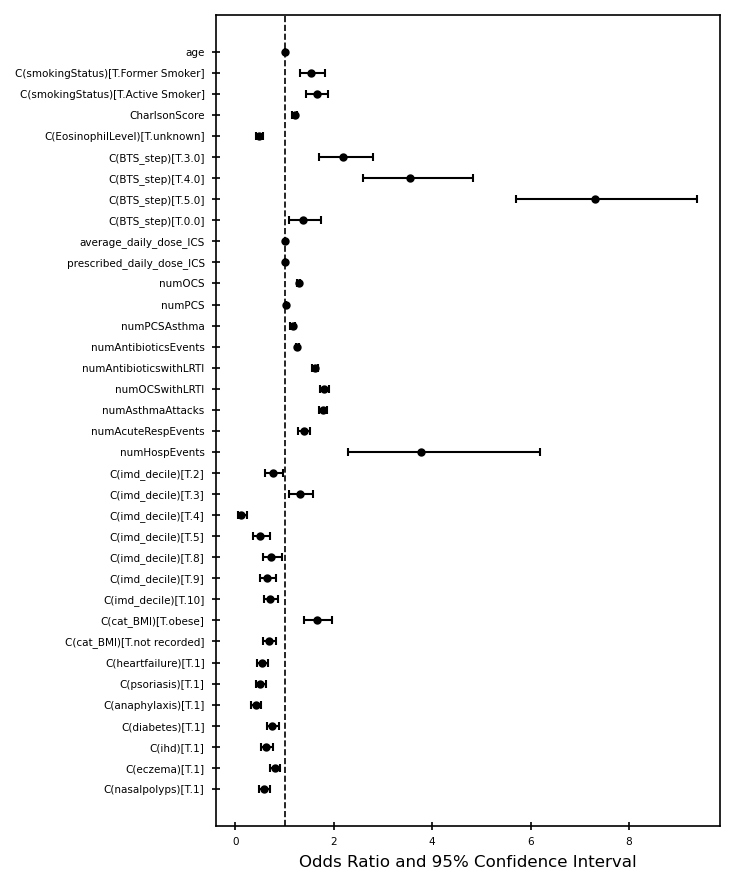

In [79]:
sign_result = result[result['Significant?'] == 'significant']
plt.figure(figsize=(5, 6), dpi=150)
ci = [sign_result.iloc[::-1]['OR'] - sign_result.iloc[::-1]['2.5%'].values, sign_result.iloc[::-1]['97.5%'].values - sign_result.iloc[::-1]['OR']]
plt.errorbar(x=sign_result.iloc[::-1]['OR'], y=sign_result.iloc[::-1].index.values, xerr=ci,
            color='black',  capsize=2, linestyle='None', elinewidth=1,
            marker='o', markersize=3, mfc="black", mec="black",barsabove=True,)
plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(direction='inout', axis='both', which='major', labelsize=5)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=8)
plt.tight_layout()
# plt.savefig('raw_forest_plot.png')
plt.show()

## Scotland

In [ ]:
data = evaluationDataScotland

# handling n = 0 in certain groups
for col in cat_vars:
    valuecounts = data[col].value_counts()
    groupsToBeExcluded = valuecounts.index[(valuecounts < 10).values].tolist()
    for group in groupsToBeExcluded:
        categories = data[col].cat.categories
        categories = np.delete(categories, np.where(categories == group))
        data[col] = pd.Categorical(data[col], categories=categories)
        print('exclude ', str(group), ' from ', str(col))
        
result = []
excluded_vars = ['PEFStatus', 'ICS_medication_possesion_ratio']
for col in features_columns:
    print(col)
    if col not in excluded_vars:
        if(len(data[col].unique())>1): #handling Singluar matrix problem
            # log_reg = sm.Logit(data[['12months']], data[[col]]).fit()
            if col in cat_vars:
                formula = "outcome_12months ~ C(" + str(col) + ")"
                log_reg = smf.logit(formula=formula, data=data).fit()
            else:
                formula = "outcome_12months ~ " + str(col)
                log_reg = smf.logit(formula=formula, data=data).fit()                

            for i in range(1,len(log_reg.params)):
                sign = ['significant' if log_reg.pvalues[i] <= 0.05 else 'not significant']
                result.append([log_reg.params.index[i], log_reg.pvalues[i], log_reg.params[i], np.exp(log_reg.params[i])] + np.exp(log_reg.conf_int().values[i]).tolist() + sign)

result = pd.DataFrame(result, columns=['Var', 'PVal', 'Beta', 'OR', '2.5%', '97.5%', 'Significant?'])
result.index = result.Var


In [ ]:
plt.figure(figsize=(5, 6), dpi=150)
ci = [result.iloc[::-1]['OR'] - result.iloc[::-1]['2.5%'].values, result.iloc[::-1]['97.5%'].values - result.iloc[::-1]['OR']]
plt.errorbar(x=result.iloc[::-1]['OR'], y=result.iloc[::-1].index.values, xerr=ci,
            color='black',  capsize=2, linestyle='None', elinewidth=1,
            marker='o', markersize=3, mfc="black", mec="black",barsabove=True,)
plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(direction='inout', axis='both', which='major', labelsize=5)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=8)
plt.tight_layout()
# plt.savefig('raw_forest_plot.png')
plt.show()

In [ ]:
sign_result = result[result['Significant?'] == 'significant']
plt.figure(figsize=(5, 6), dpi=150)
ci = [sign_result.iloc[::-1]['OR'] - sign_result.iloc[::-1]['2.5%'].values, sign_result.iloc[::-1]['97.5%'].values - sign_result.iloc[::-1]['OR']]
plt.errorbar(x=sign_result.iloc[::-1]['OR'], y=sign_result.iloc[::-1].index.values, xerr=ci,
            color='black',  capsize=2, linestyle='None', elinewidth=1,
            marker='o', markersize=3, mfc="black", mec="black",barsabove=True,)
plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(direction='inout', axis='both', which='major', labelsize=5)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=8)
plt.tight_layout()
# plt.savefig('raw_forest_plot.png')
plt.show()

## All Data

In [73]:
data = pd.concat([EnglandData, evaluationData])
data['system'] = pd.Categorical(data['system'], categories=['Vision', 'SystemOne', 'EMIS'])
# handling n = 0 in certain groups
for col in cat_vars:
    valuecounts = data[col].value_counts()
    groupsToBeExcluded = valuecounts.index[(valuecounts < 10).values].tolist()
    for group in groupsToBeExcluded:
        categories = data[col].cat.categories
        categories = np.delete(categories, np.where(categories == group))
        data[col] = pd.Categorical(data[col], categories=categories)
        print('exclude ', str(group), ' from ', str(col))
        
result = []
excluded_vars = ['imd_decile', 'PEFStatus', 'ICS_medication_possesion_ratio']
for col in features_columns:
    print(col)
    if col not in excluded_vars:
        if(len(data[col].unique())>1): #handling Singluar matrix problem
            # log_reg = sm.Logit(data[['12months']], data[[col]]).fit()
            if col in cat_vars:
                formula = "outcome_12months ~ C(" + str(col) + ")"
                log_reg = smf.logit(formula=formula, data=data).fit()
            else:
                formula = "outcome_12months ~ " + str(col)
                log_reg = smf.logit(formula=formula, data=data).fit()                

            for i in range(1,len(log_reg.params)):
                sign = ['significant' if log_reg.pvalues[i] <= 0.05 else 'not significant']
                result.append([log_reg.params.index[i], log_reg.pvalues[i], log_reg.params[i], np.exp(log_reg.params[i])] + np.exp(log_reg.conf_int().values[i]).tolist() + sign)

result = pd.DataFrame(result, columns=['Var', 'PVal', 'Beta', 'OR', '2.5%', '97.5%', 'Significant?'])
result.index = result.Var


exclude  female  from  sex
exclude  male  from  sex
sex
age
Optimization terminated successfully.
         Current function value: 0.195483
         Iterations 7
ethnic_group
Optimization terminated successfully.
         Current function value: 0.196802
         Iterations 7
smokingStatus
Optimization terminated successfully.
         Current function value: 0.195865
         Iterations 7
CharlsonScore
Optimization terminated successfully.
         Current function value: 0.196246
         Iterations 7
PEFStatus
EosinophilLevel
Optimization terminated successfully.
         Current function value: 0.195396
         Iterations 7
BTS_step
Optimization terminated successfully.
         Current function value: 0.186031
         Iterations 7
average_daily_dose_ICS
Optimization terminated successfully.
         Current function value: 0.192153
         Iterations 7
prescribed_daily_dose_ICS
Optimization terminated successfully.
         Current function value: 0.192490
         Iterations 7

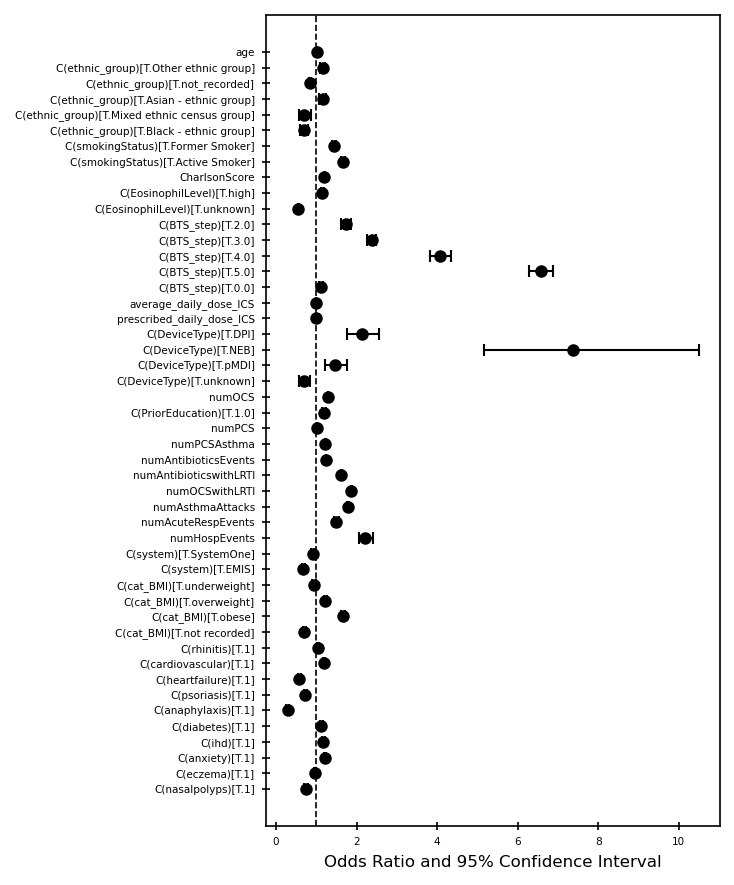

In [74]:
plt.figure(figsize=(5, 6), dpi=150)
ci = [result.iloc[::-1]['OR'] - result.iloc[::-1]['2.5%'].values, result.iloc[::-1]['97.5%'].values - result.iloc[::-1]['OR']]
plt.errorbar(x=result.iloc[::-1]['OR'], y=result.iloc[::-1].index.values, xerr=ci,
            color='black',  capsize=3, linestyle='None', elinewidth=1,
            marker='o', markersize=5, mfc="black", mec="black",barsabove=True,)
plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(direction='inout', axis='both', which='major', labelsize=5)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=8)
plt.tight_layout()
# plt.savefig('raw_forest_plot.png')
plt.show()

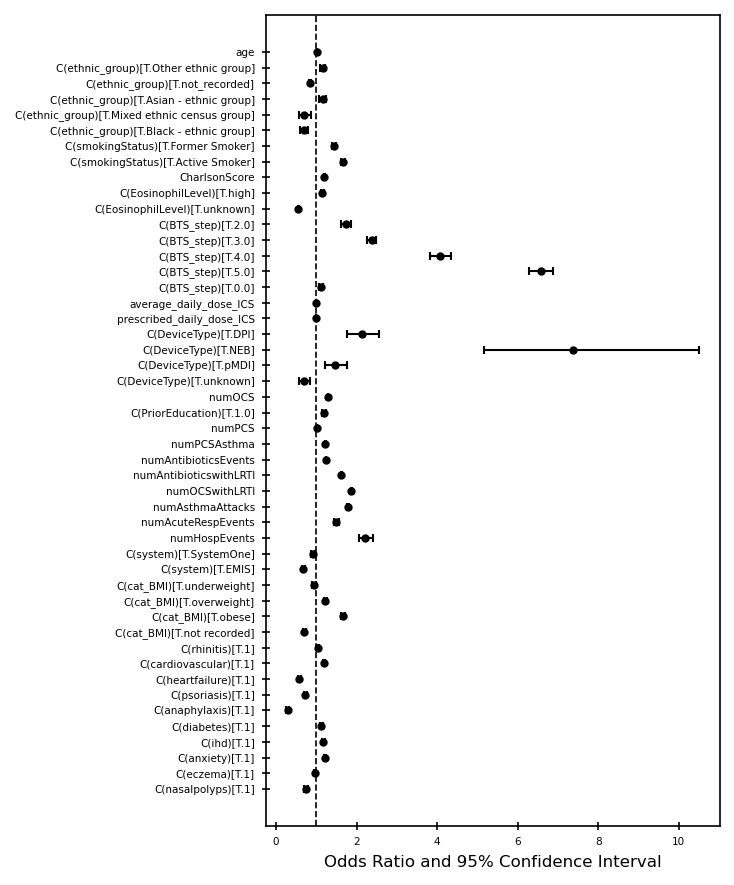

In [75]:
sign_result = result[result['Significant?'] == 'significant']
plt.figure(figsize=(5, 6), dpi=150)
ci = [sign_result.iloc[::-1]['OR'] - sign_result.iloc[::-1]['2.5%'].values, sign_result.iloc[::-1]['97.5%'].values - sign_result.iloc[::-1]['OR']]
plt.errorbar(x=sign_result.iloc[::-1]['OR'], y=sign_result.iloc[::-1].index.values, xerr=ci,
            color='black',  capsize=2, linestyle='None', elinewidth=1,
            marker='o', markersize=3, mfc="black", mec="black",barsabove=True, )
plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(direction='inout', axis='both', which='major', labelsize=5)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=8)
plt.tight_layout()
# plt.savefig('raw_forest_plot.png')
plt.show()

In [76]:
result[result.Var.str.contains('system')]

,Var,PVal,Beta,OR,2.5%,97.5%,Significant?
Var,,,,,,,
C(system)[T.SystemOne],C(system)[T.SystemOne],1.164422e-03,-0.092312,0.911821,0.862409,0.964063,significant
C(system)[T.EMIS],C(system)[T.EMIS],2.700169e-44,-0.400024,0.670304,0.633698,0.709025,significant


## All Evaluation Data

In [53]:
data = evaluationData
# handling n = 0 in certain groups
for col in cat_vars:
    valuecounts = data[col].value_counts()
    groupsToBeExcluded = valuecounts.index[(valuecounts < 10).values].tolist()
    for group in groupsToBeExcluded:
        categories = data[col].cat.categories
        categories = np.delete(categories, np.where(categories == group))
        data[col] = pd.Categorical(data[col], categories=categories)
        print('exclude ', str(group), ' from ', str(col))
        
result = []
excluded_vars = ['PEFStatus', 'ICS_medication_possesion_ratio']
# excluded_vars = []
for col in features_columns:
    print(col)
    if col not in excluded_vars:
        if(len(data[col].unique())>1): #handling Singluar matrix problem
            # log_reg = sm.Logit(data[['12months']], data[[col]]).fit()
            if col in cat_vars:
                formula = "outcome_12months ~ C(" + str(col) + ")"
                log_reg = smf.logit(formula=formula, data=data).fit()
            else:
                formula = "outcome_12months ~ " + str(col)
                log_reg = smf.logit(formula=formula, data=data).fit()                

            for i in range(1,len(log_reg.params)):
                sign = ['significant' if log_reg.pvalues[i] < 0.05 else 'not significant']
                result.append([log_reg.params.index[i], log_reg.pvalues[i], log_reg.params[i], np.exp(log_reg.params[i])] + np.exp(log_reg.conf_int().values[i]).tolist() + sign)

result = pd.DataFrame(result, columns=['Var', 'PVal', 'Beta', 'OR', '2.5%', '97.5%', 'Significant?'])
result.index = result.Var


sex
age
Optimization terminated successfully.
         Current function value: 0.243360
         Iterations 7
ethnic_group
Optimization terminated successfully.
         Current function value: 0.244902
         Iterations 20
smokingStatus
Optimization terminated successfully.
         Current function value: 0.243576
         Iterations 7
CharlsonScore
Optimization terminated successfully.
         Current function value: 0.243786
         Iterations 7
PEFStatus
EosinophilLevel
Optimization terminated successfully.
         Current function value: 0.241618
         Iterations 7
BTS_step


/tmp/ipykernel_1871/526805829.py:29: RuntimeWarning: overflow encountered in exp
  result.append([log_reg.params.index[i], log_reg.pvalues[i], log_reg.params[i], np.exp(log_reg.params[i])] + np.exp(log_reg.conf_int().values[i]).tolist() + sign)


Optimization terminated successfully.
         Current function value: 0.234315
         Iterations 7
average_daily_dose_ICS
Optimization terminated successfully.
         Current function value: 0.244704
         Iterations 7
prescribed_daily_dose_ICS
Optimization terminated successfully.
         Current function value: 0.244709
         Iterations 7
ICS_medication_possesion_ratio
DeviceType
Optimization terminated successfully.
         Current function value: 0.242506
         Iterations 7
numOCS
Optimization terminated successfully.
         Current function value: 0.233249
         Iterations 7
PriorEducation
Optimization terminated successfully.
         Current function value: 0.245120
         Iterations 7
numPCS
Optimization terminated successfully.
         Current function value: 0.238015
         Iterations 7
numPCSAsthma
Optimization terminated successfully.
         Current function value: 0.243815
         Iterations 7
numAntibioticsEvents
Optimization terminated succes

In [59]:
result[result.Var.str.contains('system')]

,Var,PVal,Beta,OR,2.5%,97.5%,Significant?
Var,,,,,,,
C(system)[T.EMIS],C(system)[T.EMIS],0.552577,0.0314,1.031898,0.930323,1.144563,not significant


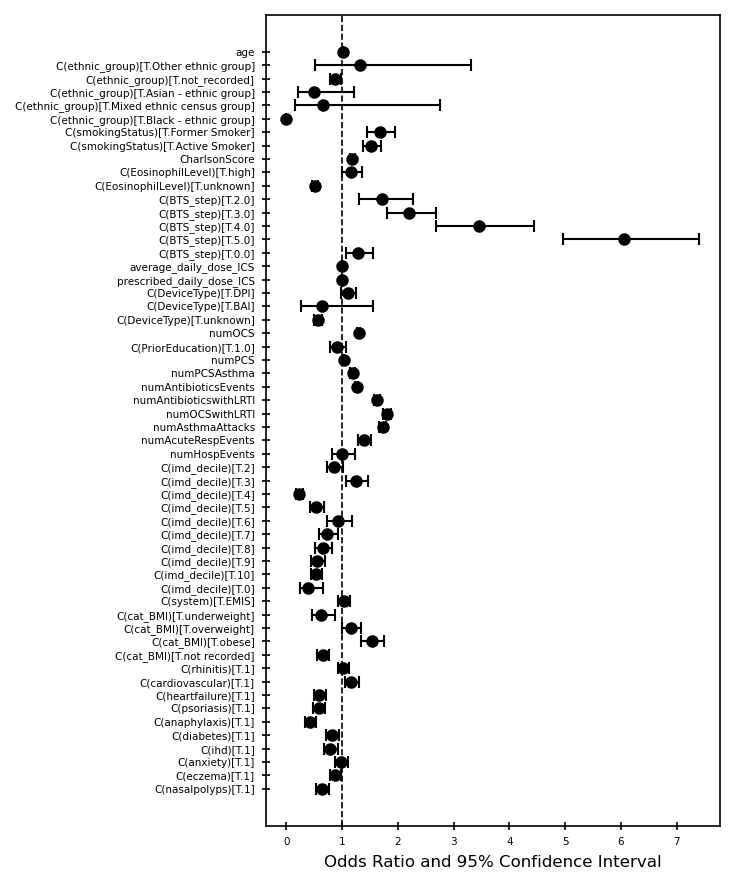

In [54]:
plt.figure(figsize=(5, 6), dpi=150)
ci = [result.iloc[::-1]['OR'] - result.iloc[::-1]['2.5%'].values, result.iloc[::-1]['97.5%'].values - result.iloc[::-1]['OR']]
plt.errorbar(x=result.iloc[::-1]['OR'], y=result.iloc[::-1].index.values, xerr=ci,
            color='black',  capsize=3, linestyle='None', elinewidth=1,
            marker='o', markersize=5, mfc="black", mec="black",barsabove=True,)
plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(direction='inout', axis='both', which='major', labelsize=5)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=8)
plt.tight_layout()
# plt.savefig('raw_forest_plot.png')
plt.show()

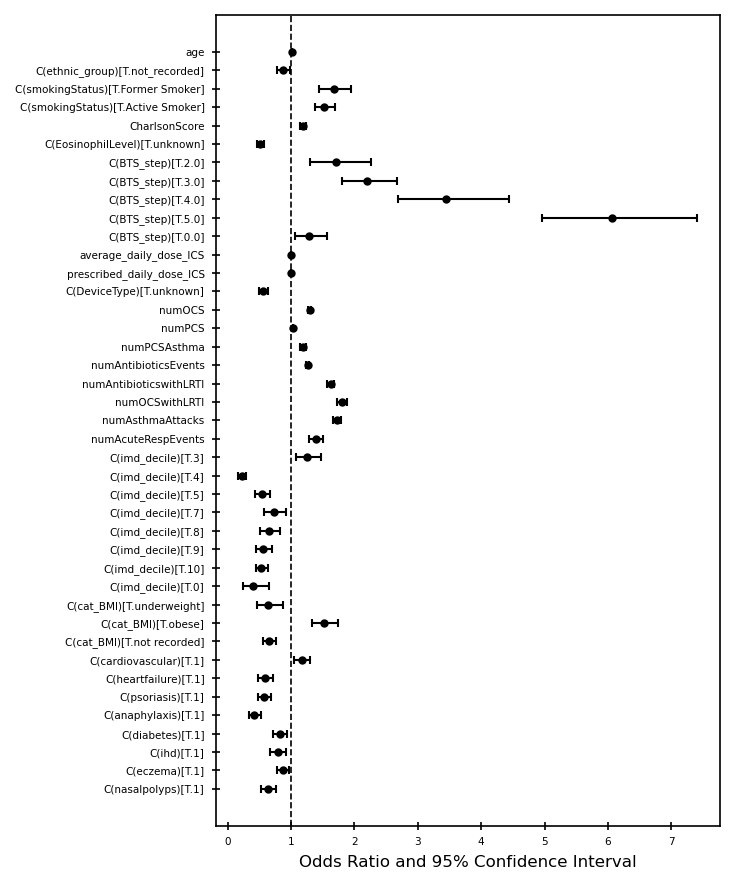

In [55]:
sign_result = result[result['Significant?'] == 'significant']
plt.figure(figsize=(5, 6), dpi=150)
ci = [sign_result.iloc[::-1]['OR'] - sign_result.iloc[::-1]['2.5%'].values, sign_result.iloc[::-1]['97.5%'].values - sign_result.iloc[::-1]['OR']]
plt.errorbar(x=sign_result.iloc[::-1]['OR'], y=sign_result.iloc[::-1].index.values, xerr=ci,
            color='black',  capsize=2, linestyle='None', elinewidth=1,
            marker='o', markersize=3, mfc="black", mec="black",barsabove=True, )
plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(direction='inout', axis='both', which='major', labelsize=5)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=8)
plt.tight_layout()
# plt.savefig('raw_forest_plot.png')
plt.show()